In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Concatenate
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from utils import get_dataset

In [2]:
def create_model(input_raster_shape=(100, 100, 1), climate_vars=8):
    # Input for the raster (100x100 grid)
    raster_input = Input(shape=input_raster_shape)

    # Convolutional layers for the raster input: spatial feature extraction
    x = Conv2D(32, (3, 3), activation='relu')(raster_input)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x)  # Flatten for concat

    # Input: climate variables
    climate_input = Input(shape=(climate_vars,))

    # Dense layers for the climate variables input
    climate_dense = Dense(32, activation='relu')(climate_input)
    climate_dense = Dense(16, activation='relu')(climate_dense)

    # Concat spatial features + climate features
    combined = Concatenate()([x, climate_dense])

    # FC after
    combined_dense = Dense(128, activation='relu')(combined)
    output = Dense(100 * 100, activation='sigmoid')(combined_dense)  # Output flattened raster

    final_model = Model(inputs=[raster_input, climate_input], outputs=output)
    final_model.compile(optimizer='adam', loss='mean_squared_error')

    return final_model

In [3]:
def process_cnn_fire(sub_df):
    X_raster = []
    X_climate_vars = []
    y_raster = []
    for i in range(len(sub_df) - 1):
        X_raster.append(sub_df.raster[i])
        X_climate_vars.append([
            sub_df.burning_index[i], 
            sub_df.evapotranspiration_al[i], 
            sub_df.fuel_moisture_1000[i], 
            sub_df.relative_humidity_max[i], 
            sub_df.specific_humidity[i], 
            sub_df.temperature_max[i], 
            sub_df.vpd[i], 
            sub_df.wind_speed[i]
        ])
        y_raster.append(sub_df.raster_flat[i + 1])
    return X_raster, X_climate_vars, y_raster

def prepare_data_cnn(df):
    all_X = []
    all_climate = []
    all_y = []
    
    for fire in list(df.FIRE_NAME.unique()):
        sub_df = df[df.FIRE_NAME == fire].reset_index(drop=True)
        X, climate, y = process_cnn_fire(sub_df)
        all_X.extend(X)
        all_climate.extend(climate)
        all_y.extend(y)
    
    return all_X, all_climate, all_y

In [4]:
df = get_dataset("../data/dataset.csv")
X_cnn, climate_cnn, y_cnn = prepare_data_cnn(df)

In [5]:
X_cnn = np.array(X_cnn)
climate_cnn = np.array(climate_cnn)
y_cnn = np.array(y_cnn)

In [6]:
scaler_climate = MinMaxScaler()
climate_cnn_scaled = scaler_climate.fit_transform(climate_cnn)
X_train, X_test, climate_train, climate_test, y_train, y_test = train_test_split(
    X_cnn, climate_cnn_scaled, y_cnn, test_size=0.2, random_state=42)

print(f"Training set shapes: X_train={X_train.shape}, climate_train={climate_train.shape}, y_train={y_train.shape}")
print(f"Test set shapes: X_test={X_test.shape}, climate_test={climate_test.shape}, y_test={y_test.shape}")

Training set shapes: X_train=(4341, 100, 100), climate_train=(4341, 8), y_train=(4341, 10000)
Test set shapes: X_test=(1086, 100, 100), climate_test=(1086, 8), y_test=(1086, 10000)


In [7]:
model = create_model(input_raster_shape=(100, 100, 1), climate_vars=8)
model.summary()

history = model.fit(
    [X_train, climate_train],
    y_train,
    epochs=50,
    batch_size=16,
    validation_data=([X_test, climate_test], y_test)
)
model.save("non_lstm_test_v1.keras")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 98, 98,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 49, 49,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 47, 47,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 23, 23,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        288 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 33856)     │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │        528 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 33872)     │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │  4,335,744 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 10000)     │  1,290,000 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,645,376 (21.54 MB)

 Trainable params: 5,645,376 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - loss: 0.1497 - val_loss: 0.0993
Epoch 2/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.0958 - val_loss: 0.0887
Epoch 3/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - loss: 0.0799 - val_loss: 0.0855
Epoch 4/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - loss: 0.0726 - val_loss: 0.0833
Epoch 5/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - loss: 0.0659 - val_loss: 0.0840
Epoch 6/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - loss: 0.0605 - val_loss: 0.0838
Epoch 7/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - loss: 0.0557 - val_loss: 0.0873
Epoch 8/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - loss: 0.0510 - val_loss: 0.0874
Epoch 9/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - loss: 0.0467 - val_loss: 0.0878
Epoch 10/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - loss: 0.0444 - val_loss: 0.0891
Epoch 11/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - loss: 0.0401 - val_loss: 0.0898
Epoch 12/50
272/272 ━━━━━━━━━━

In [8]:
test_loss = model.evaluate([X_test, climate_test], y_test)
print(f"Test Loss: {test_loss}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0947
Test Loss: 0.09746034443378448


In [18]:
sample_index = 1000
sample_X_raster = X_test[sample_index]
sample_climate = climate_test[sample_index]
sample_y = y_test[sample_index]

sample_X_raster = sample_X_raster.reshape(1, 100, 100, 1)
sample_climate = sample_climate.reshape(1, 8)

prediction = model.predict([sample_X_raster, sample_climate])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


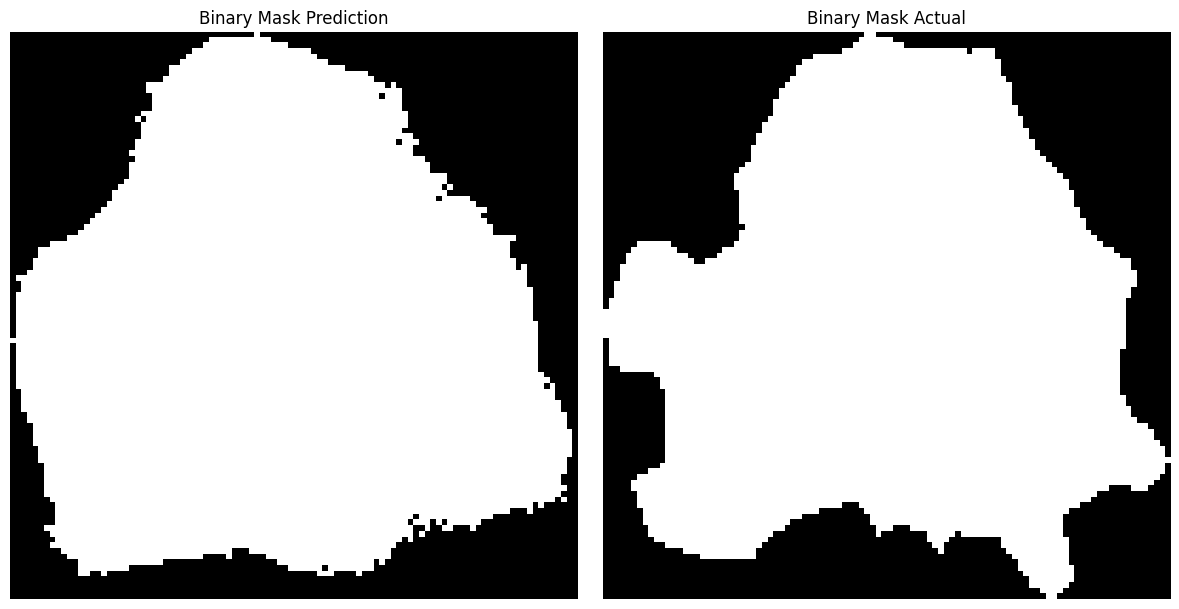

In [19]:
binary_mask = (prediction.reshape((100, 100)) > 0.5).astype(np.uint8)
actual_mask = sample_y.reshape((100, 100))

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(binary_mask, cmap='gray')
axes[0].set_title('Binary Mask Prediction')
axes[0].axis('off')

axes[1].imshow(actual_mask, cmap='gray')
axes[1].set_title('Binary Mask Actual')
axes[1].axis('off')

plt.tight_layout()
plt.show()

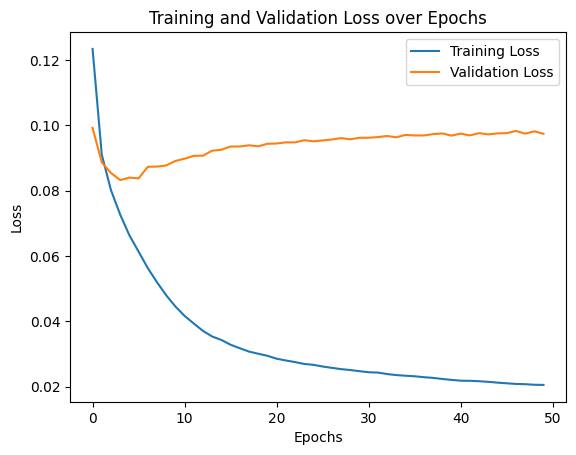

In [13]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')

plt.legend()
plt.show()

_______________________

In [ ]:
import matplotlib.pyplot as plt
binary_mask = (prediction.reshape((100, 100)) > 0.5).astype(np.uint8)
plt.imshow(binary_mask, cmap='gray')
plt.title('Binary Mask Prediction')
plt.show()

In [ ]:
plt.imshow(sample_y.reshape((100, 100)), cmap='gray')
plt.title('Binary Mask Actual')
plt.show()